Universidad Galileo<br/>
Maestría de Ciencia de Datos<br/>
Statistical Learning 1<br/>
Jose Godoy<br/>
Carnet 22000570<br/>
2 de junio 2022<br/>
<br/>
Tarea 2<br/>
Parte 1<br/>

# Importando librerías

In [1]:
#Importando librerías
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
#Importanto TensorFlow
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
tf.enable_eager_execution()
from tensorflow.keras.callbacks import TensorBoard
#Librerias auxiliares
import os
import datetime
from IPython.display import Image
#Variable de entorno tf
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Instructions for updating:
non-resource variables are not supported in the long term


# Datos

## Cargando datos del proyecto

In [2]:
data = pd.read_csv('covid_19_clean_complete.csv')

Transformación de la variable Date

In [3]:
dates=pd.to_datetime(data.loc[:,"Date"], format='%Y-%m-%d')
data.loc[:,"Date"]=(dates-dates.min()).dt.days

Casos confirmados para Guatemala

<AxesSubplot:xlabel='Date', ylabel='Confirmed'>

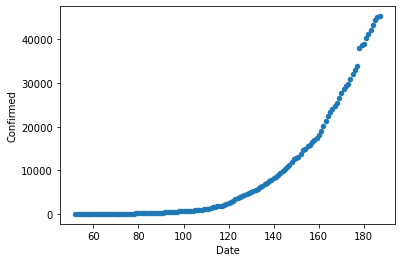

In [4]:
GT_confirmed = data[(data["Country/Region"] == 'Guatemala') & (data["Confirmed"] > 0)].copy()
GT_confirmed.plot.scatter(x = "Date",y="Confirmed")

Separación de datos para entrenamiento y pruebas

In [5]:
msk = np.random.rand(GT_confirmed.shape[0]) < 0.8

#Datos de entrenamiento
data_training = GT_confirmed[msk]
#Datos de validación y pruebas
data_validation = GT_confirmed[~msk]

training = int(data_training.shape[0])

print("Shape training data: ", data_training.shape)
print("Shape test data: ", data_validation.shape)

Shape training data:  (112, 10)
Shape test data:  (24, 10)


Transformación de variables

<AxesSubplot:xlabel='Date', ylabel='ln(confirmed)'>

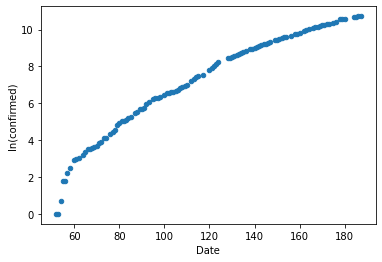

In [6]:
datos = data_training.loc[:,["Date","Confirmed"]]

datos["ln(confirmed)"] = np.log(data_training["Confirmed"])
datos.plot.scatter(x = "Date",y="ln(confirmed)")

# TensorFlow

Función auxiliar

In [7]:
def my_reshape(my_array):
    return my_array.reshape(my_array.shape[0], 1)

## Modelo Líneal

In [8]:
class ModeloLineal:
            
    def __init__(self, x, y, tamaño_muestra, lr, epochs, batch_size, mb, string, iteraciones):
        tf.reset_default_graph()
        self.g = tf.Graph()
        
        #Definición de variables a usar en la clase
        self.x = np.hstack(( my_reshape(x), np.ones((x.size,1)) ))
        self.lr = lr
        self.y = y
        self.mb = mb
        self.epochs = epochs
        self.tamaño_muestra = tamaño_muestra
        self.batch_size = batch_size
        self.string = string
        self.iteraciones = iteraciones
        
    def predecir(self):
        
        #Grafo
        with self.g.as_default():
            
            #Definición de variables
            mb = tf.Variable([[0.0], [0.0]], dtype=tf.dtypes.float64, name="mb")
            lr = tf.Variable(0.0, name="lr", dtype=tf.dtypes.float64)
            x = tf.Variable(tf.zeros((self.batch_size, 2), dtype=tf.dtypes.float64), name="x")
            y = tf.Variable(tf.zeros((self.batch_size, 1), dtype=tf.dtypes.float64), name="y")
            
            #hipotesis
            with tf.name_scope("modelo"):
                y_estimado = tf.matmul(x, mb, name="y_estimado")
            
            #Cálculo de error
            with tf.name_scope("error"):
                error = tf.math.multiply(
                    tf.cast(1/2, dtype=tf.dtypes.float64),
                    tf.reduce_mean(
                        tf.math.square(
                            tf.math.subtract(
                                y, 
                                y_estimado
                            )
                        ) 
                    )
                )
            
            #Registro de error
            error_summary = tf.summary.scalar("error",error)
            
            #Gradiente
            with tf.name_scope("gradiente"):
                grad_mb = tf.gradients(error,[mb])
            
            #Siguiente paso
            with tf.name_scope("siguiente"):
                mb_final = tf.subtract(mb, tf.multiply(lr,grad_mb[0]))
        
        #Sesión
        with tf.Session(graph=self.g) as sesion:
            #Escritura de log
            writer = tf.summary.FileWriter(
                os.path.join(
                    "./logs", 
                    self.string+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                ), 
                sesion.graph
            )
            
            #Epochs
            for epoch in range(self.epochs):
                #Iteraciones
                for iteracion in range(self.iteraciones):
                    #Tamaño de muestra
                    muestra_inicio =int(tamaño_muestra/epochs)*epoch
                    muestra_fin = muestra_inicio+self.batch_size

                    #TensorFlow
                    [err,self.mb,es] = sesion.run([error, mb_final,error_summary], feed_dict = {
                        mb: self.mb,
                        x:np.array(self.x[muestra_inicio:muestra_fin,:]).reshape([-1,2]),
                        y:np.array(self.y[muestra_inicio:muestra_fin]).reshape([-1,1]),
                        lr: self.lr
                    }) 

                    #Escritura de resultados
                    writer.add_summary(es, epoch*epochs + iteracion)
                
            writer.close()
            
        return [self.mb]

Grafo de Tensorflow

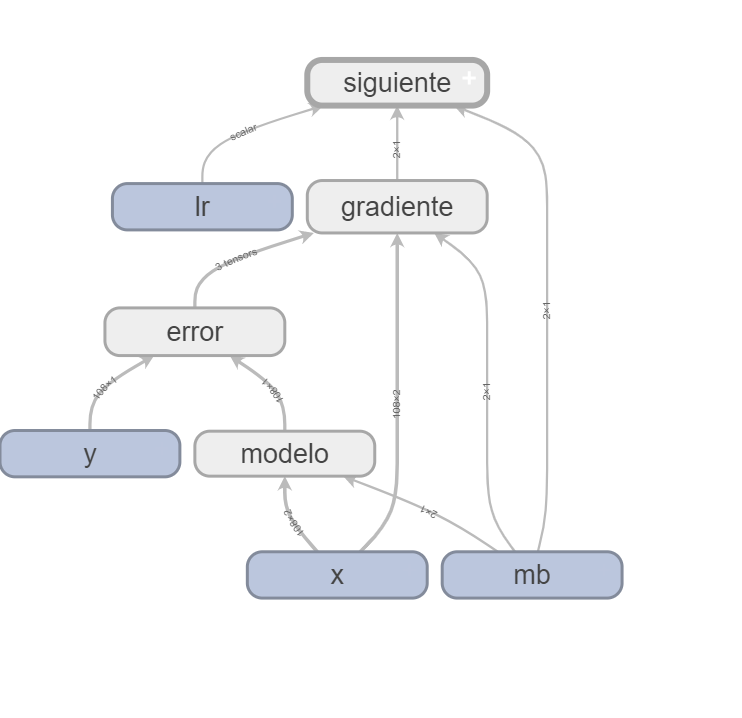

In [9]:
Image(filename='p1-grafo.png')

# Experimentos

Datos generales a utilizar en los experimentos

In [10]:
tamaño_muestra=training
x=datos["Date"].to_numpy()
y=datos["ln(confirmed)"].to_numpy()

## Experimento 1

In [11]:
#Numero de iteraciones
epochs = 1
#Learning rate
lr = 0.01
#Tamaño de mini batch
batch_size = tamaño_muestra
#Hipotesis
mb = [[0], [0]]
#String de configuración
string = "exp1_batch_lr0.01_1000i_"
#Iteraciones
iteraciones=1000
data_training
modelo_variable1 = ModeloLineal(x, y, tamaño_muestra, lr, epochs, batch_size, mb, string, iteraciones)
resultado1 = modelo_variable1.predecir()

## Experimento 2

In [12]:
#Numero de iteraciones
epochs = 1
#Learning rate
lr = 0.0001
#Tamaño de mini batch
batch_size = tamaño_muestra
#Hipotesis
mb = [[0], [0]]
#String de configuración
string = "exp2_batch_lr0.0001_1000i_"
#Iteraciones
iteraciones=1000
data_training
modelo_variable2 = ModeloLineal(x, y, tamaño_muestra, lr, epochs, batch_size, mb, string, iteraciones)
resultado2 = modelo_variable2.predecir()

## Experimento 3

In [13]:
#Numero de iteraciones
epochs = 1
#Learning rate
lr = 0.0001
#Tamaño de mini batch
batch_size = tamaño_muestra
#Hipotesis
mb = [[0], [0]]
#String de configuración
string = "exp3_batch_lr0.0001_5000i_"
#Iteraciones
iteraciones=5000
data_training
modelo_variable3 = ModeloLineal(x, y, tamaño_muestra, lr, epochs, batch_size, mb, string, iteraciones)
resultado3 = modelo_variable3.predecir()

## Comparación de resultados

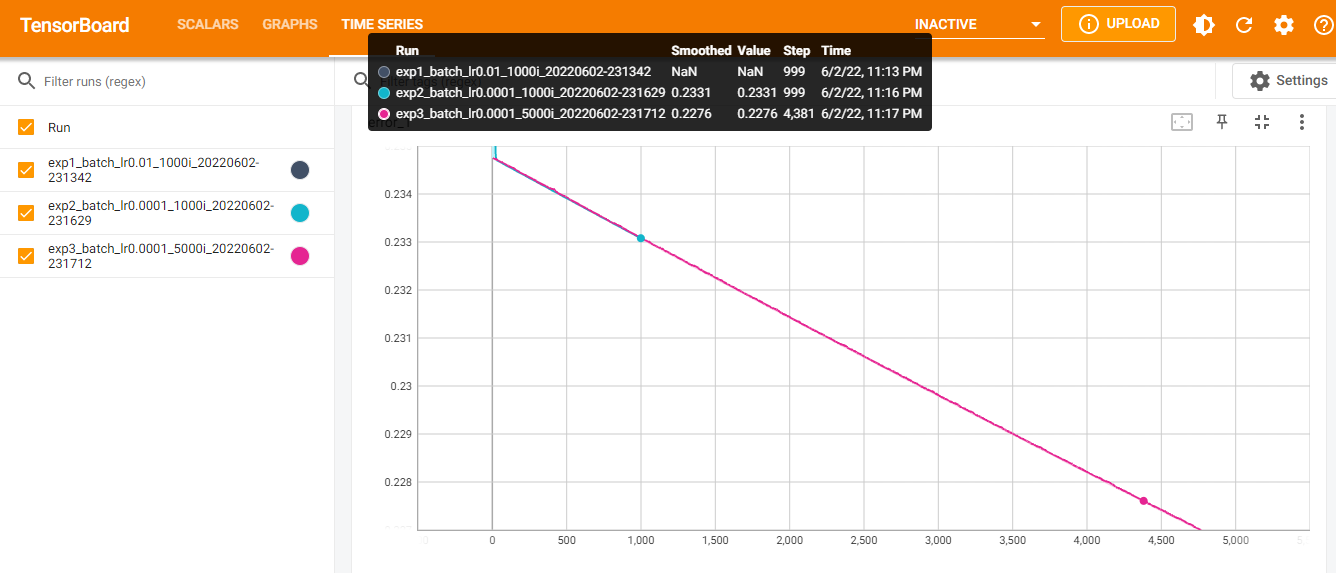

In [14]:
Image(filename='p1-r1.png')

El experimento (1) tendió al infinito, se modificó el lr, con 1000 iteraciones se logró descender a un error de 0.233, con 5000 iteraciones a 0.227, esto significa que 4k iteraciones más el error se redujo 0.006, con esto se concluye que el mejor modelo lineal es el tercero.

# Análisis de resultados

Las siguientes funciones realizan una predicción con ScikitLean, predicen con el resultado de TF, así mismo se agregó el promedio de ambas predciones.

In [15]:
def scikitlearn_regresion_lineal(x, y):
    scikitlearn_modelo = LinearRegression().fit(x, y)
    return scikitlearn_modelo

def predecir_modelo_tf(x, mb):
    matriz_auxiliar = np.hstack((x, np.ones(x.shape) ))
    r = np.matmul(matriz_auxiliar, mb)
    r = np.e**r
    return r

def calcular_estimacion(scikitlearn, mb_tf, x):
    scikitlearn_prediccion = scikitlearn.predict(x)
    modelo_manual_predict = predecir_modelo_tf(x, mb_tf)
    promedio = np.nanmean(np.array([scikitlearn_prediccion, modelo_manual_predict]), axis=0)
    return (scikitlearn_prediccion,modelo_manual_predict, promedio)

Cálculando:

In [16]:
x_real = my_reshape(data_validation["Date"].to_numpy())
y_real =  my_reshape(data_validation["Confirmed"].to_numpy())

x_training_sl = my_reshape(data_training["Date"].to_numpy())
y_training_sl = my_reshape(data_training["Confirmed"].to_numpy())

scikitlearn = scikitlearn_regresion_lineal(x_training_sl, y_training_sl)
estimacion = calcular_estimacion(scikitlearn, resultado3[0], x_real) 

Comparación con gráfica de barras

[287.98233368748197, -4547.242384513192, -2129.630025412855]


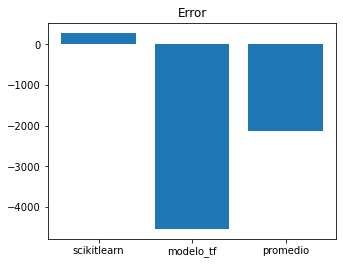

In [17]:
def grafica_barras(scikitlearn, modelo_manual, promedio, titulo):
    plt.rcParams["figure.figsize"] = (4, 3)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    titulos = ['scikitlearn', 'modelo_tf', 'promedio']
    error = [np.nanmean(scikitlearn), np.nanmean(modelo_manual), np.nanmean(promedio)]
    print(error)
    ax.bar(titulos,error)
    plt.title(titulo)
    plt.show()

#Errores para la primera variable con el valor más predictivo
error_scikitlearn = y_real - estimacion[0]
error_modelo_tf = y_real - estimacion[1]
error_promedio = y_real - estimacion[2]
grafica_barras(error_scikitlearn, error_modelo_tf, error_promedio, "Error")

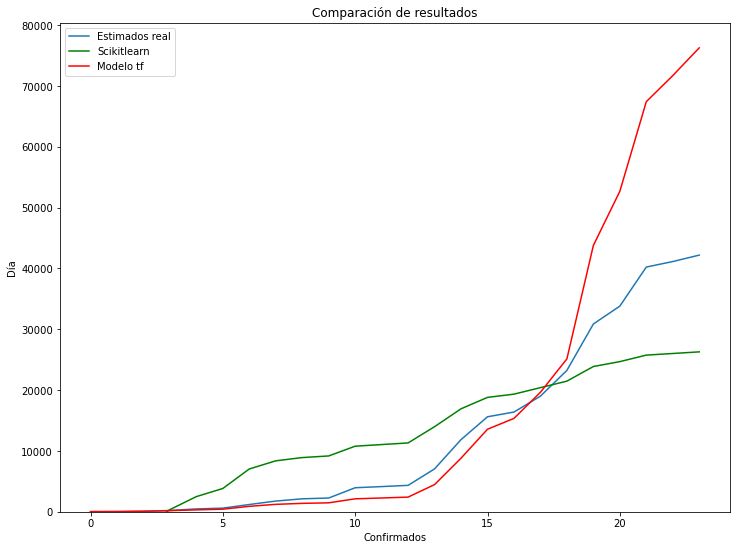

In [18]:
#Comparación con gráfica de líneas

def grafica_lineas(precio, scikitlearn, modelo_manual, titulo):
    index = np.arange(0, precio.shape[0], 1)
    
    plt.rcParams["figure.figsize"] = (12, 9)
    f, ax = plt.subplots(1)
    plt.title(titulo)
    plt.xlabel("Confirmados")
    plt.ylabel('Día')
    ax.plot(index, precio)
    ax.plot(index, scikitlearn, color="g")
    ax.plot(index, modelo_manual, color="r")
    ax.legend(['Estimados real', 'Scikitlearn', 'Modelo tf'])
    ax.set_ylim(ymin=0)
    plt.show(f)
    
grafica_lineas(y_real, estimacion[0], estimacion[1], "Comparación de resultados")


## Predicción para el 30 de mayo

In [41]:
fecha="2022-06-03"
fecha_a_predecir=pd.to_datetime([fecha], format='%Y-%m-%d')
dia=(fecha_a_predecir-dates.min()).days[0]

Predicción para el 3 de junio 2022 utilizando el modelo de tensorflow:

In [42]:
print(predecir_modelo_tf(np.array([dia]), resultado3[0])[0])

1.2275820415981428e+23


In [ ]:
Predicción para el 3 de junio 2022 utilizando el modelo de Scikitlearn:

In [43]:
print(scikitlearn.predict(my_reshape(np.array([dia])))[0][0])

208063.55798196976


# Conclusión

Según tablerocovid.mspas.gob.gt, los casos activos son de 4040, ninguno de los dos modelos da un resultado que se acerque a la fecha actual. Una de las razones es que el modelo se creó con datos de hasta el 27 de julio 2020, también hay que factores externos que influyen en en este modelo.

Fecha máxima de datos del modelo 2020-07-27 00:00:00


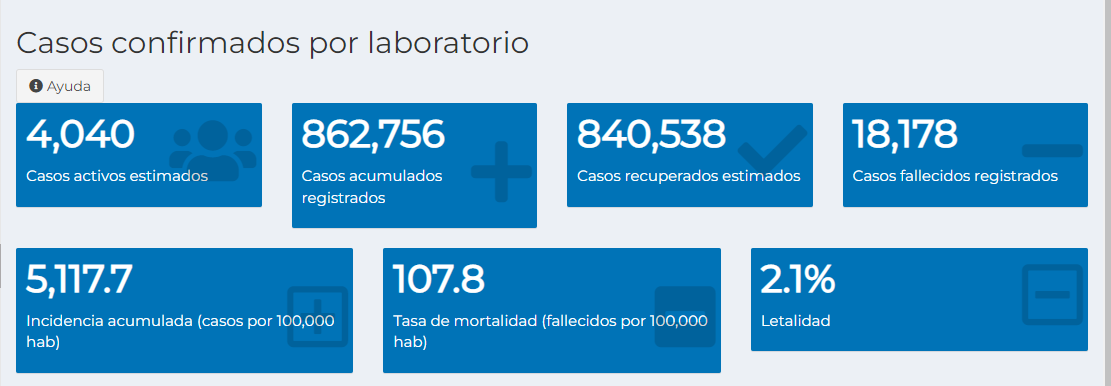

In [46]:
print("Fecha máxima de datos del modelo", dates.max())
Image(filename='p1-mspas.png')